# WEEK6：实现脉冲神经元


在 `spikingjelly` 中，我们约定，只能输出脉冲，即0或1的神经元，都可以称之为“脉冲神经元”。使用脉冲神经元的网络，进而也可以称之为脉冲神经元网络(Spiking Neural Networks, SNNs)。

In [1]:
import torch
from spikingjelly.activation_based import neuron
from spikingjelly import visualizing
from matplotlib import pyplot as plt

新建一个IF神经元层：

In [2]:
if_layer = neuron.IFNode()

In [3]:
print(if_layer.v)

0.0


IF神经元层有一些构造参数，我们需要关注下面几个重要的参数：
- v_threshold ： 神经元的阈值电压
- v_reset ： 神经元的重置电压。如果不为 None，当神经元释放脉冲后，电压会被重置为 v_reset；如果设置为 None，则电压会被减去 v_threshold
- surrogate_function ： 反向传播时用来计算脉冲函数梯度的替代函数

In [4]:
x = torch.rand(size=[2, 3])
if_layer(x)
print(f'x.shape={x.shape}, if_layer.v.shape={if_layer.v.shape}')
# x.shape=torch.Size([2, 3]), if_layer.v.shape=torch.Size([2, 3])
if_layer.reset()

x = torch.rand(size=[4, 5, 6])
if_layer(x)
print(f'x.shape={x.shape}, if_layer.v.shape={if_layer.v.shape}')
# x.shape=torch.Size([4, 5, 6]), if_layer.v.shape=torch.Size([4, 5, 6])
if_layer.reset()

x.shape=torch.Size([2, 3]), if_layer.v.shape=torch.Size([2, 3])
x.shape=torch.Size([4, 5, 6]), if_layer.v.shape=torch.Size([4, 5, 6])


脉冲神经元是有状态的，在输入下一个样本前，一定要先调用 reset() 函数清除之前的状态。
$V[t]$  和输入  $X[t]$  的关系是什么样的? 在脉冲神经元中，  $V[t]$  不仅取决于当前时刻的输入  $X[t]$  ，还 取决于它在上一个时刻末的膜电位  $V[t-1]$  。

通常使用阈下（指的是膜电位不超过阈值电压 V_{threshold} 时）神经动态方程 $\frac{\mathrm{d} V(t)}{\mathrm{d} t}=f(V(t),X(t))$, 描述连续时间的脉冲神经元的充电过程，例如对于IF神经元，充电方程为：
$\frac{\mathrm{d} V(t)}{\mathrm{d} t}=V(t)+X(t)$

`spikingjelly.activation_based.neuron` 中的神经元，使用离散的差分方程来近似连续的微分方程。在差分方程的视角下，IF神经元的充电方程为：
$V[t]-V[t-1]=X[t]$

因此可以得到$V[t]$的表达式为
$V[t]=f(V[t-1], X[t])=V[t-1]+X[t]$


释放脉冲消耗了神经元之前积累的电荷，因此膜电位会有一个瞬间的降低，即膜电位的重置。在SNN中，对膜电位重置的实现，有2种方式：
- Hard方式：释放脉冲后，膜电位直接被设置成重置电压：$V[t]=V_{\text {reset }}$
- Soft方式：释放脉冲后，膜电位减去阈值电压：$V[t]=V[t]-V_{\text {threshold }}$

可以发现，对于使用Soft方式的神经元，并不需要重置电压$V_{reset}$这个变量。

`spikingjelly.activation_based.neuron` 中的神经元，在构造函数的参数之一 v_reset，默认为 1.0 ，表示神经元使用Hard方式；若设置为 None，则会使用Soft方式。

## 描述离散脉冲神经元的三个方程

至此，可以用充电、放电、重置，这3个离散方程来描述任意的离散脉冲神经元。充电、放电方程为：

$\begin{aligned}
H[t] &=f(V[t-1], X[t]) \\
S[t] &=\Theta\left(H[t]-V_{\text {threshold }}\right)
\end{aligned}$

其中$\Theta(x)$即为构造函数参数中的 `surrogate_function`，是一个阶跃函数：
$\Theta(x)=\left\{\begin{array}{ll}
1, & x \geq 0 \\
0, & x<0
\end{array}\right.$

Hard方式重置方程为：

$V[t]=H[t] \cdot(1-S[t])+V_{\text {reset }} \cdot S[t]$

Soft方式重置方程为：

$V[t]=H[t]-V_{\text {threshold }} \cdot S[t]$

其中  $X[t]$  是外源输入，例如电压增量；为了避免混淆，我们使用  $H[t]$  表示神经元充电后、释放脉 冲前的膜电位；  $V[t]$  是神经元释放脉冲后的膜电位；$f(V[t-1], X[t])$ 是神经元的状态更新方程， 不同的神经元，区别就在于更新方程不同。

![](image/2022-07-29-10-31-13.png)

## 仿真

这个IF神经元层只有1个神经元。它的膜电位和输出脉冲随着时间变化情况如下：

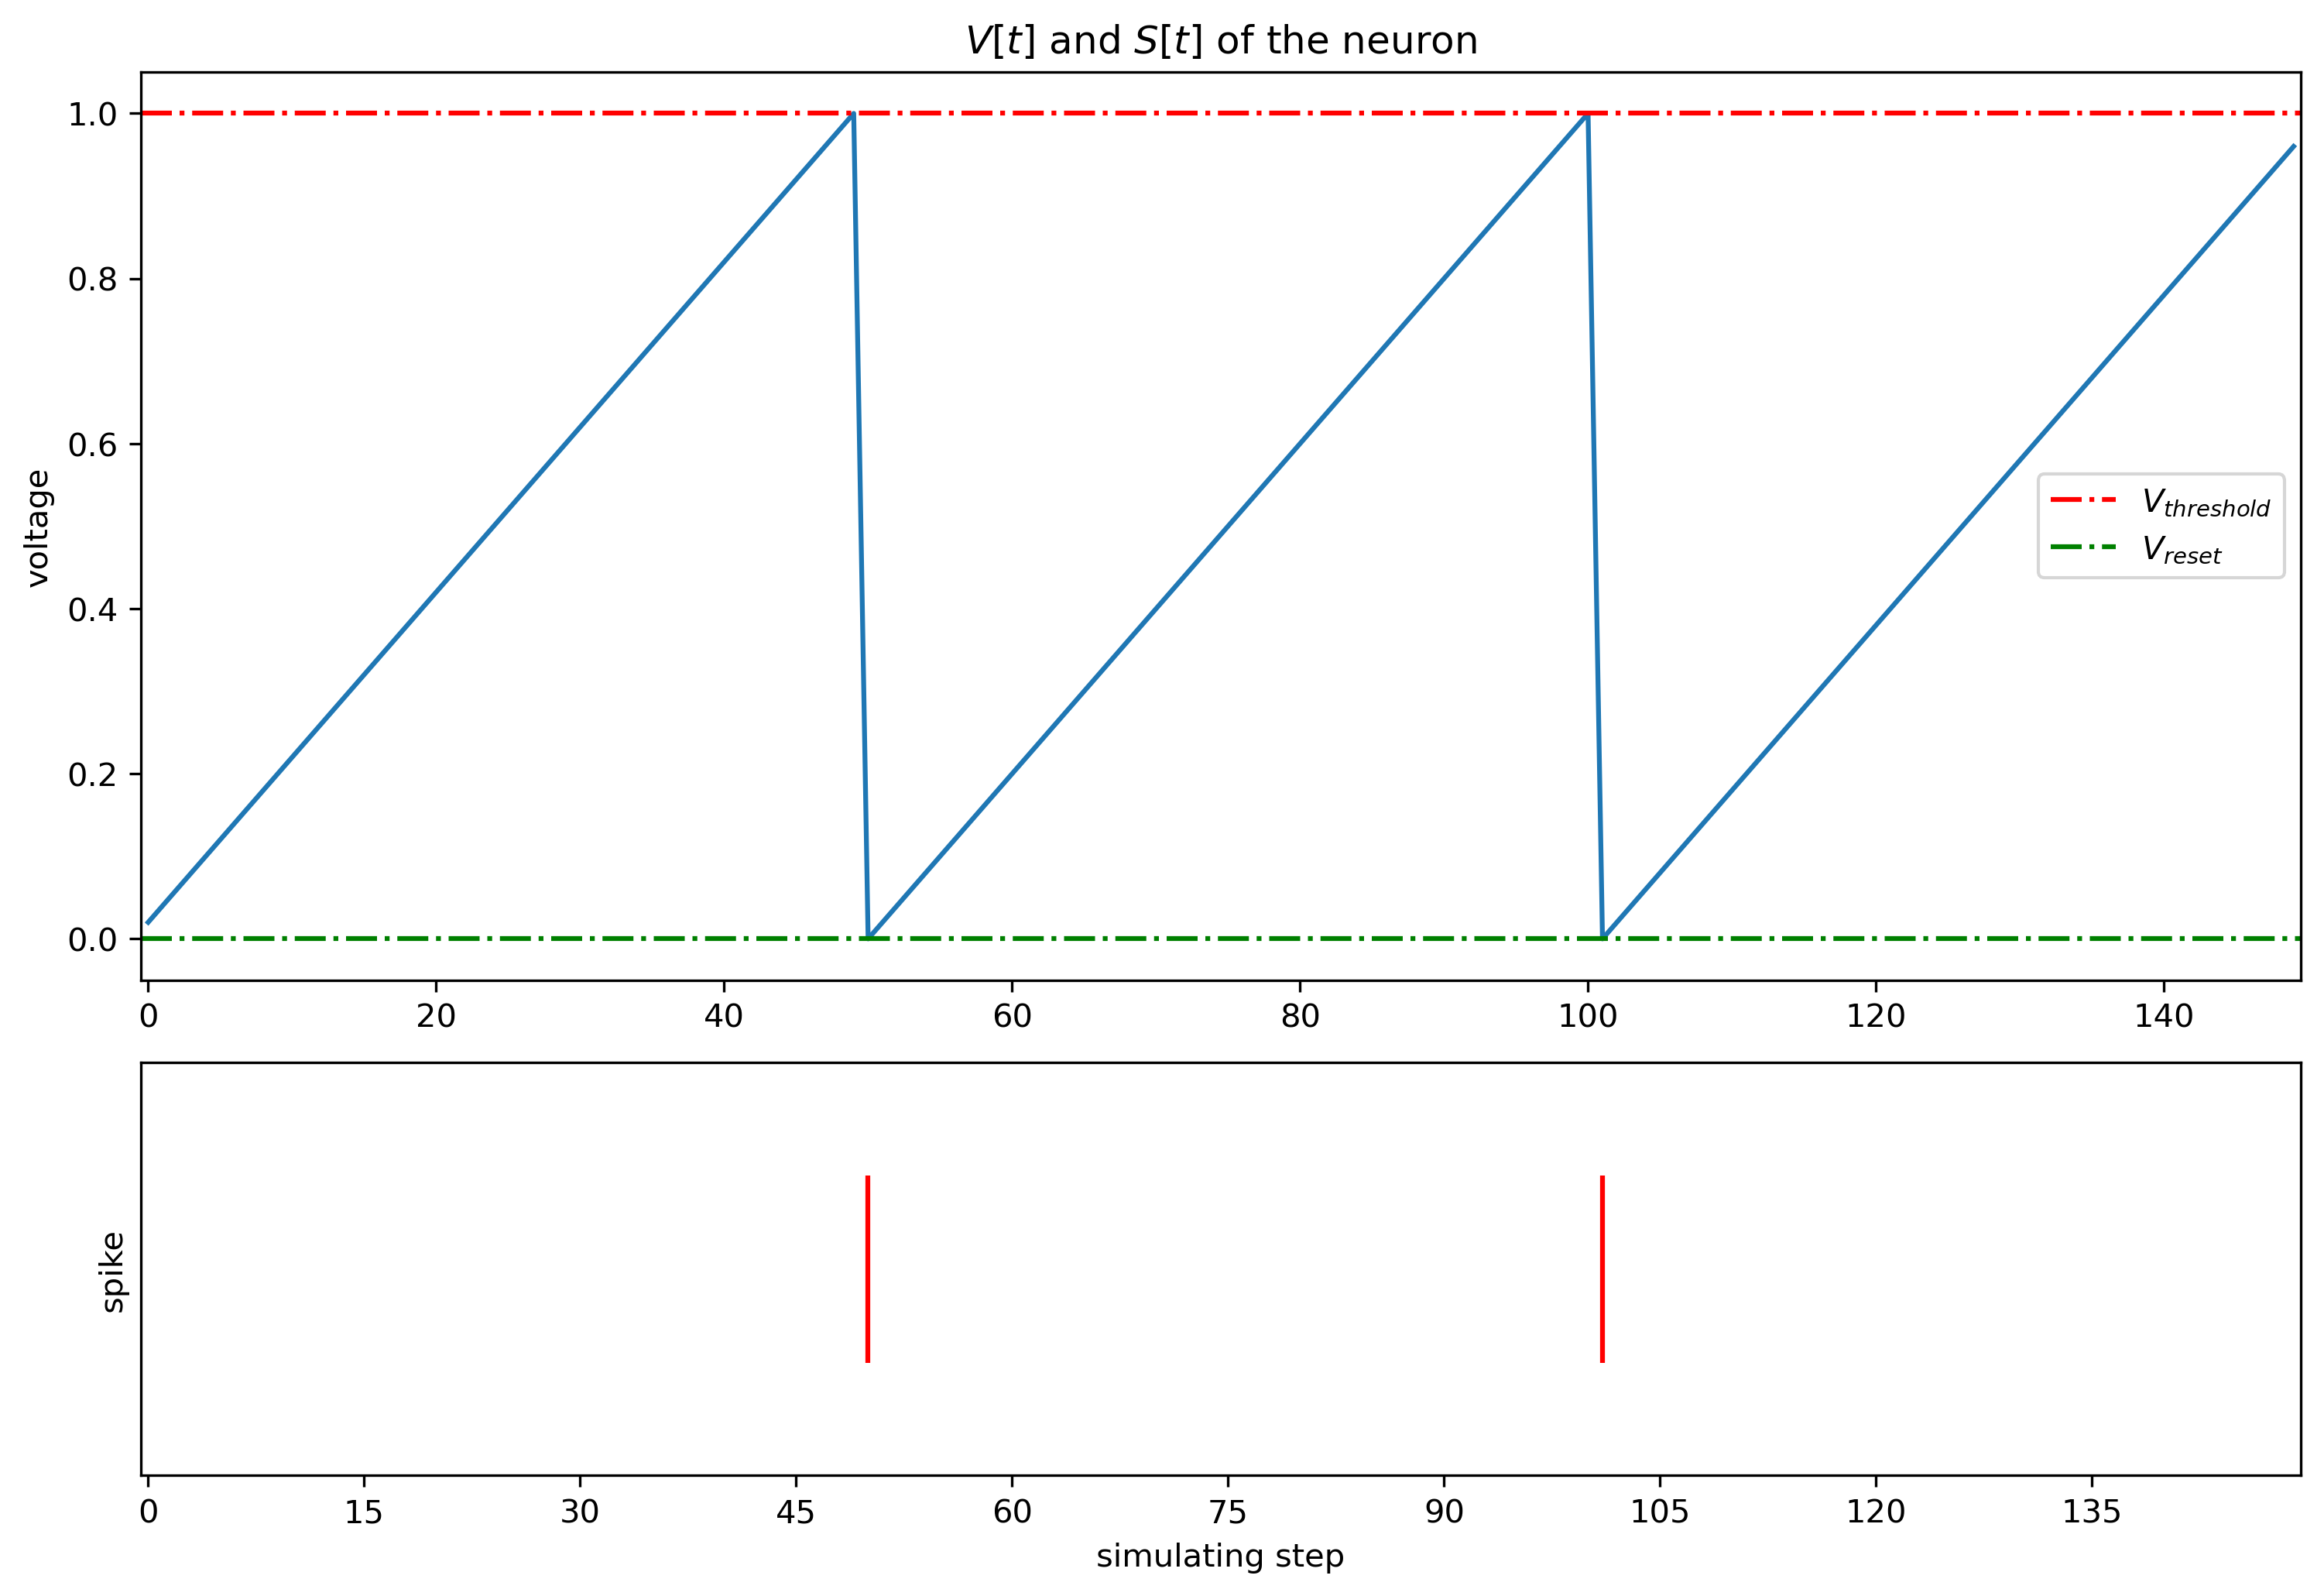

In [5]:
if_layer.reset()
x = torch.as_tensor([0.02])
T = 150
s_list = []
v_list = []
for t in range(T):
    s_list.append(if_layer(x))
    v_list.append(if_layer.v)

dpi = 300
figsize = (12, 8)
visualizing.plot_one_neuron_v_s(torch.cat(v_list).numpy(), torch.cat(s_list).numpy(), v_threshold=if_layer.v_threshold,
                                v_reset=if_layer.v_reset,
                                figsize=figsize, dpi=dpi)
plt.show()

下面我们将神经元层重置，并给与 `shape=[32]` 的输入，查看这32个神经元的膜电位和输出脉冲：

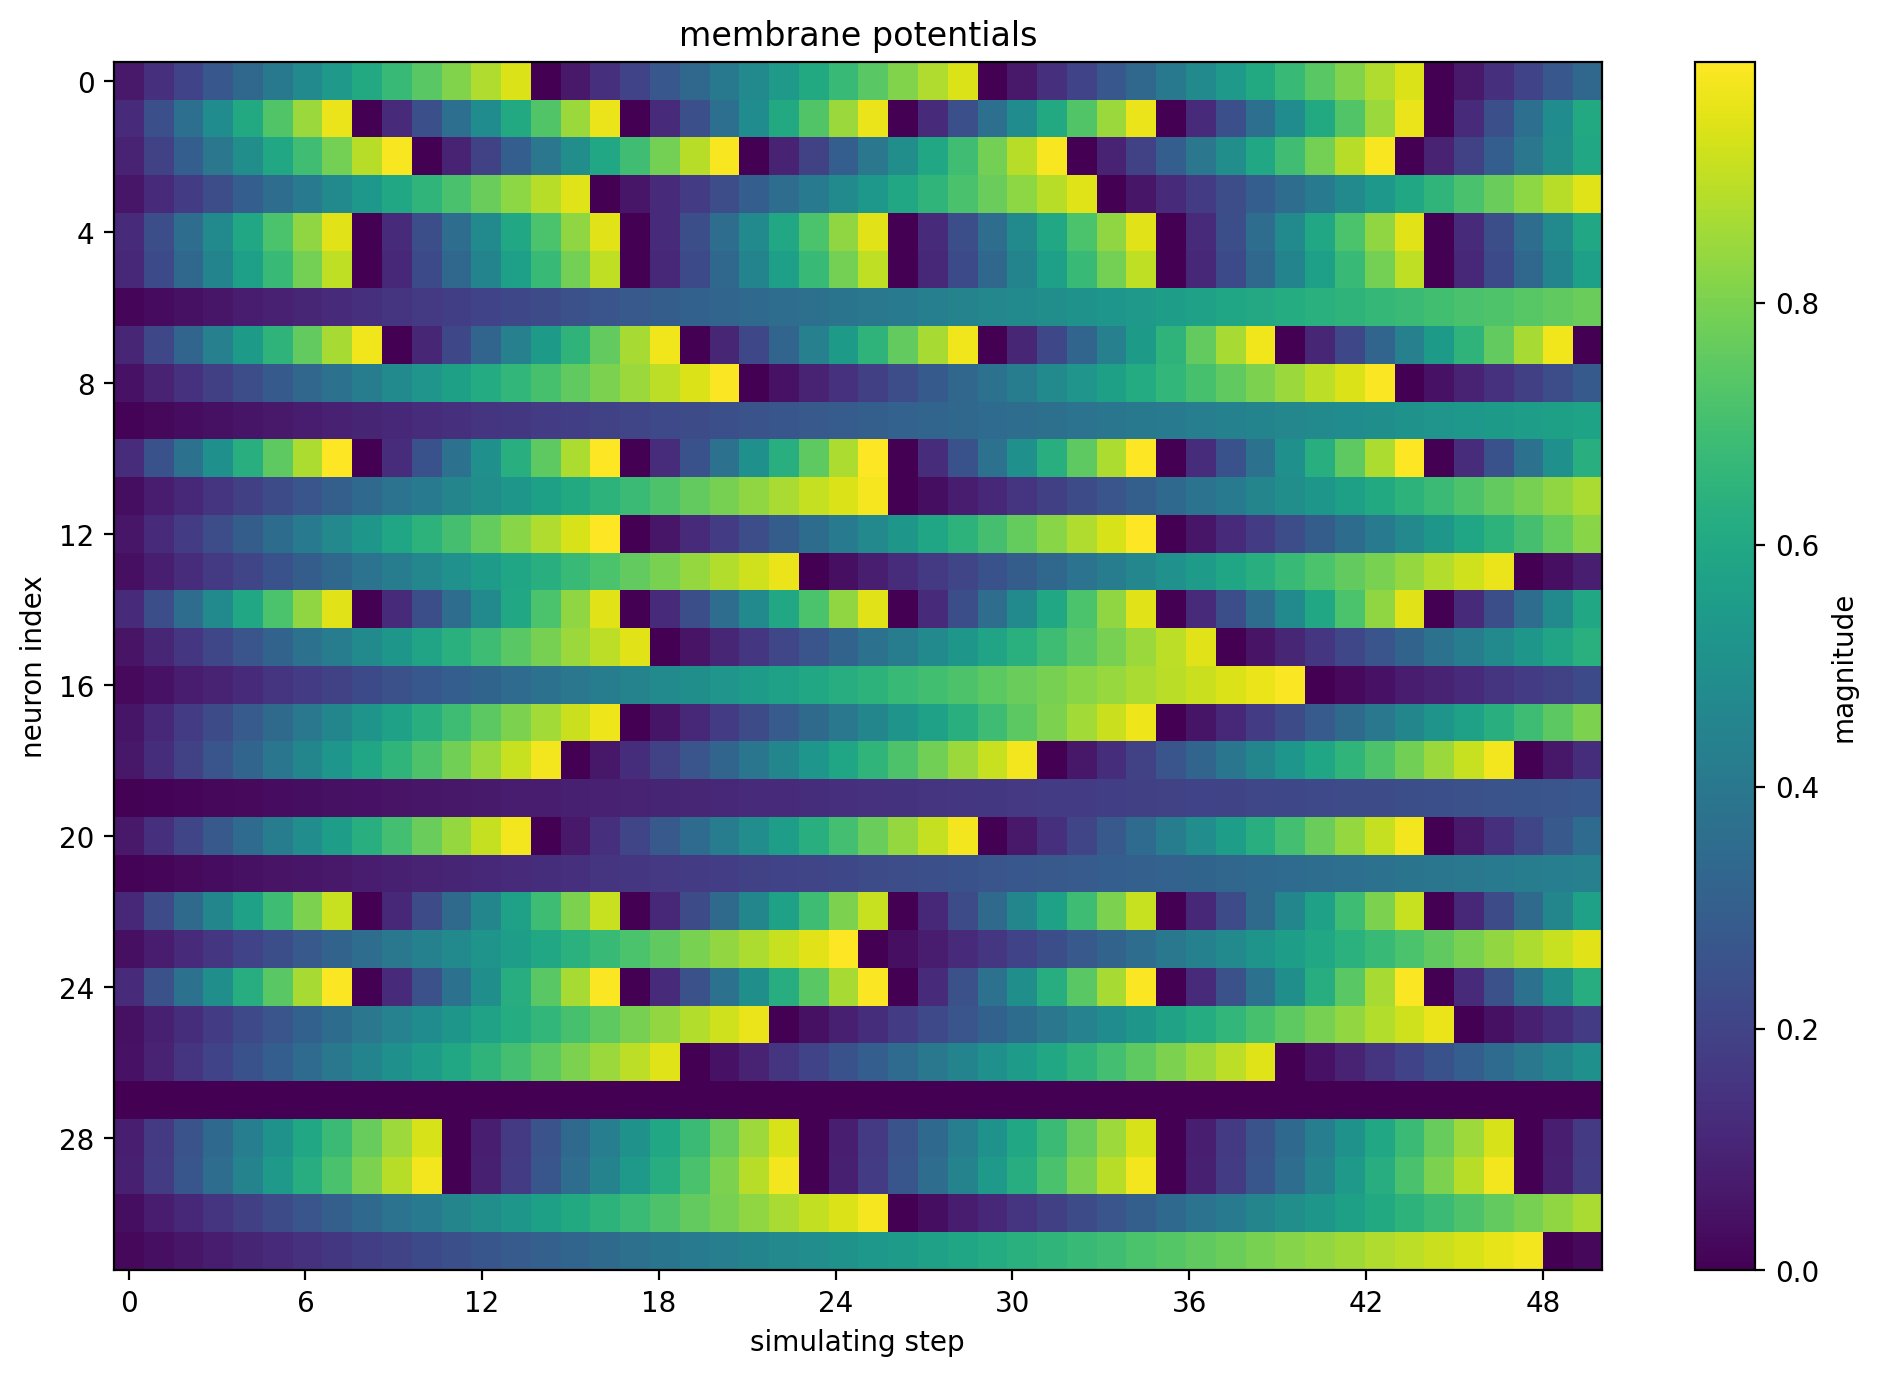

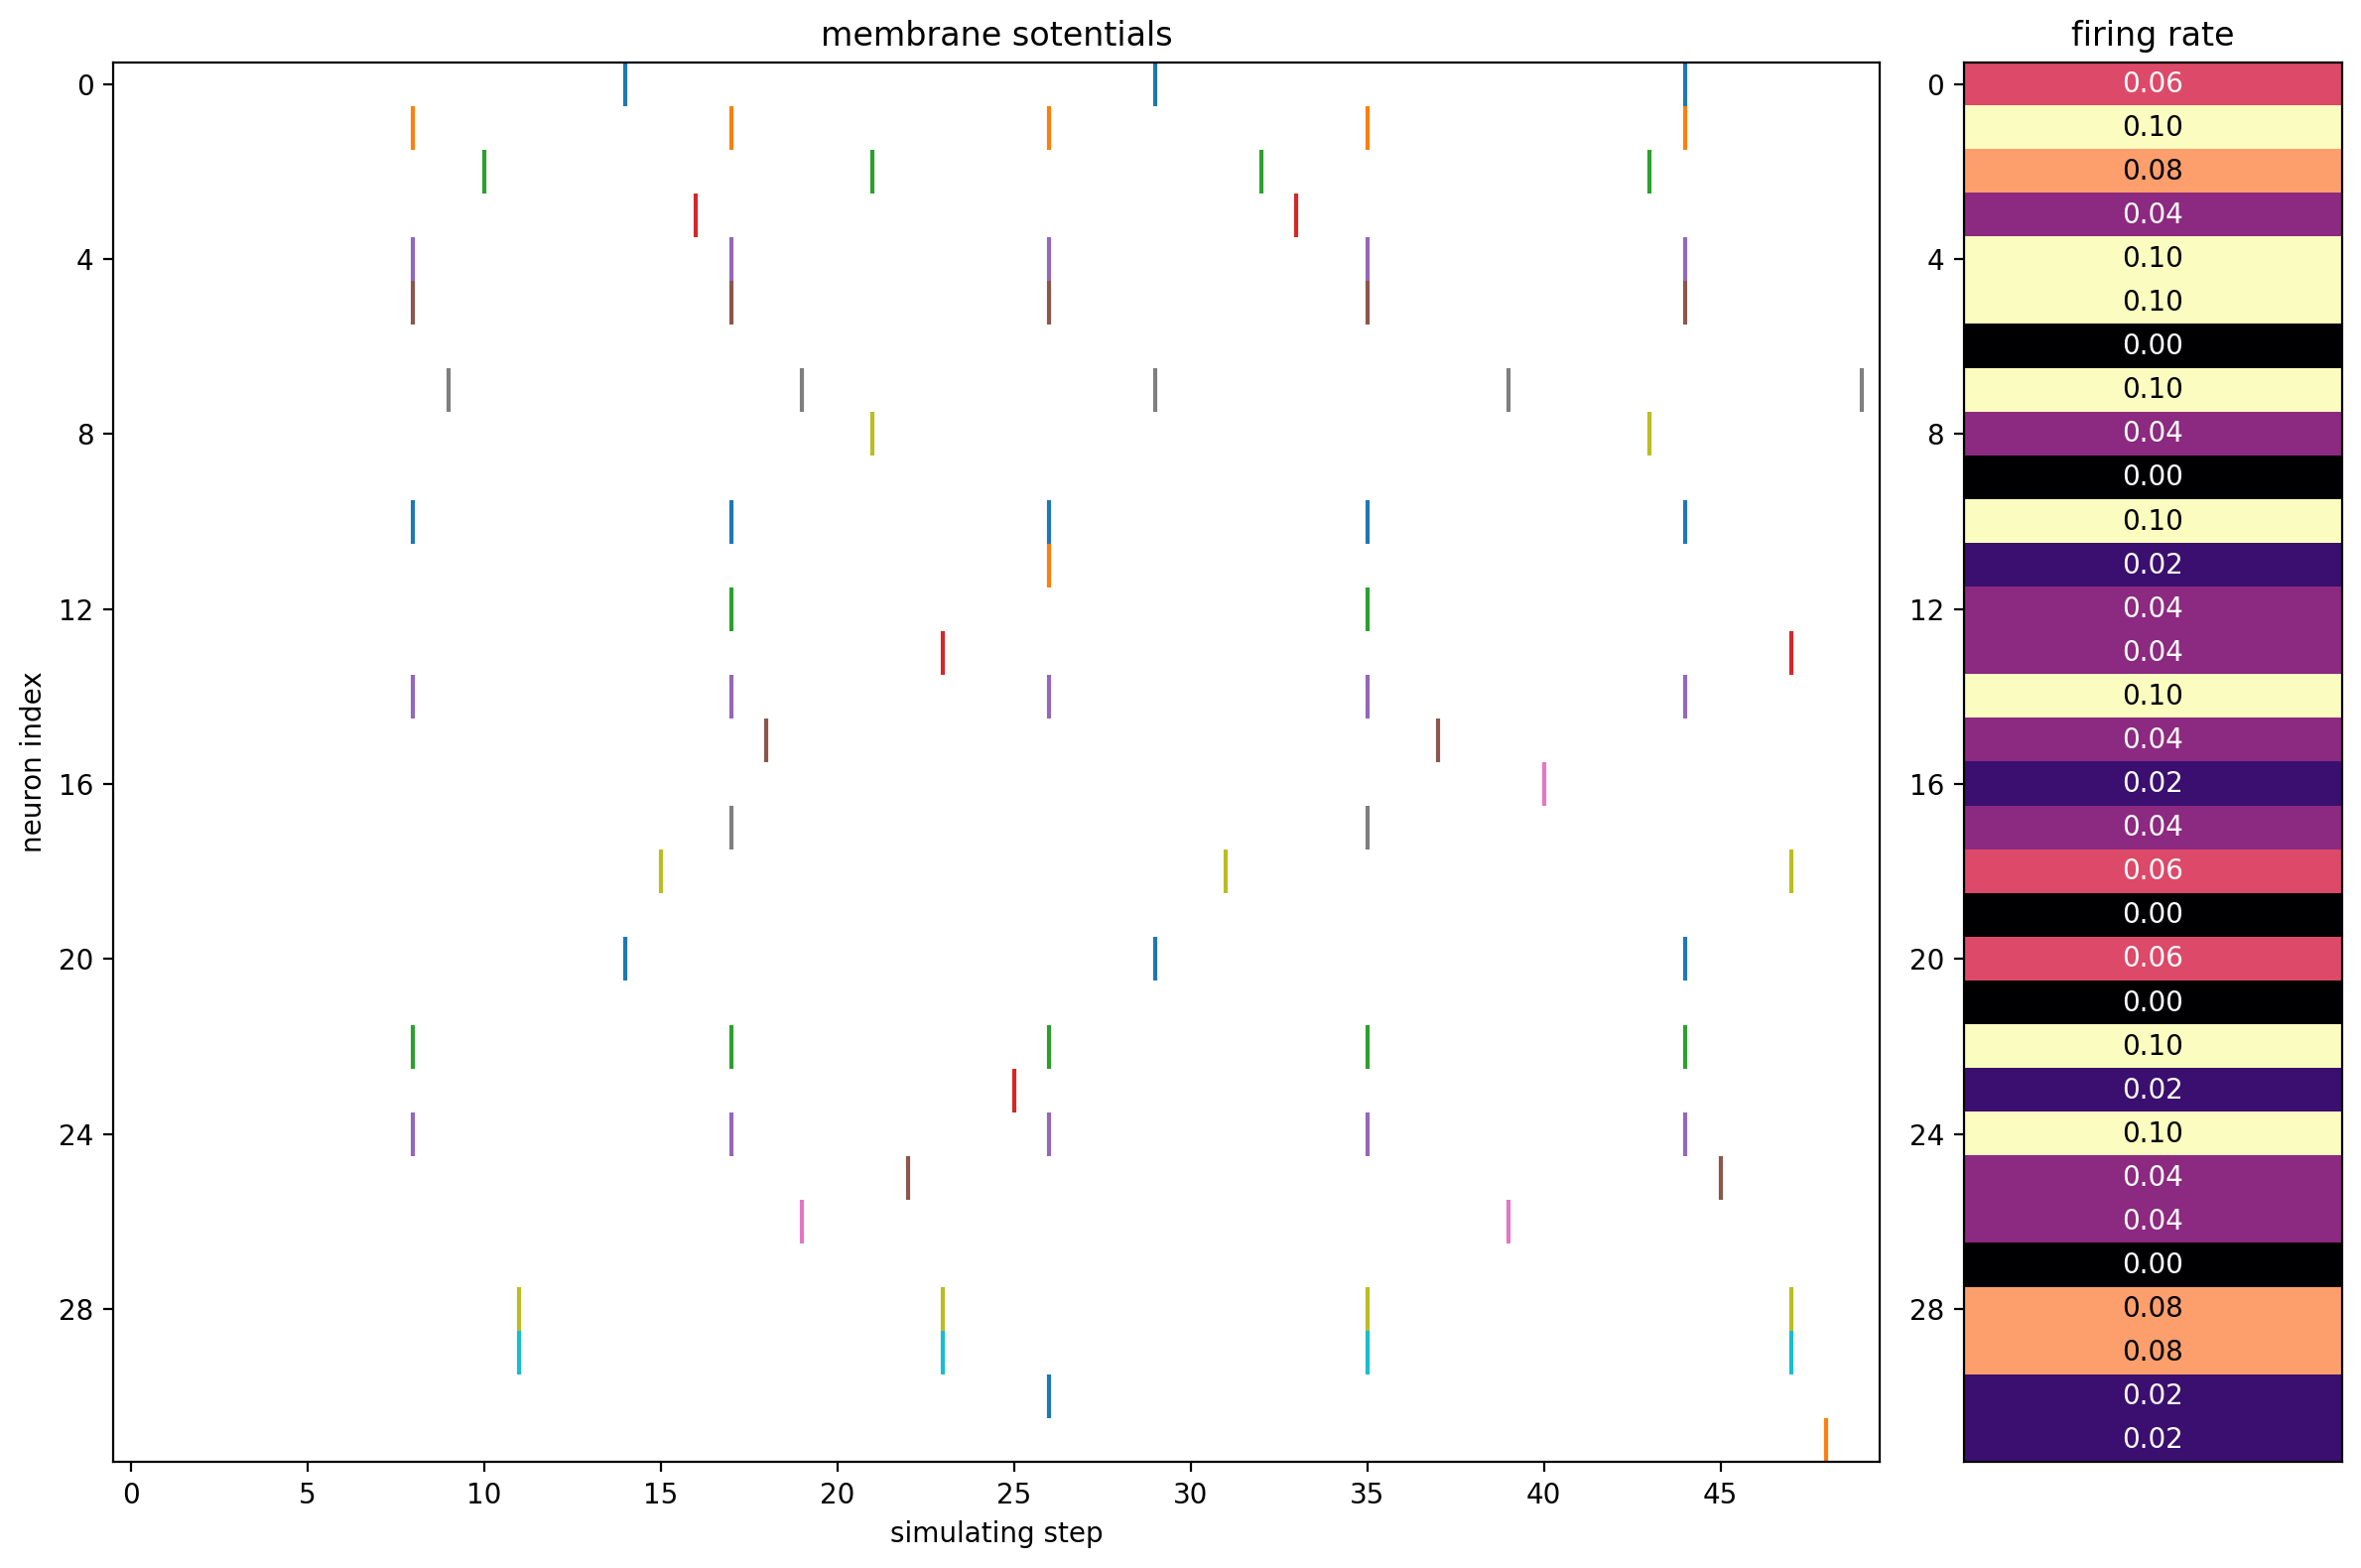

In [6]:
if_layer.reset()
T = 50
x = torch.rand([32]) / 8.
s_list = []
v_list = []
for t in range(T):
    s_list.append(if_layer(x).unsqueeze(0))
    v_list.append(if_layer.v.unsqueeze(0))

s_list = torch.cat(s_list)
v_list = torch.cat(v_list)

figsize = (12, 8)
dpi = 200
visualizing.plot_2d_heatmap(array=v_list.numpy(), title='membrane potentials', xlabel='simulating step',
                            ylabel='neuron index', int_x_ticks=True, x_max=T, figsize=figsize, dpi=dpi)


visualizing.plot_1d_spikes(spikes=s_list.numpy(), title='membrane sotentials', xlabel='simulating step',
                        ylabel='neuron index', figsize=figsize, dpi=dpi)

plt.show()

## 自定义神经元

In [7]:
import torch
from spikingjelly.activation_based import neuron

class SquareIFNode(neuron.BaseNode):

    def neuronal_charge(self, x: torch.Tensor):
        self.v = self.v + x ** 2

sif_layer = SquareIFNode()

T = 4
N = 1
x_seq = torch.rand([T, N])
print(f'x_seq={x_seq}')

for t in range(T):
    yt = sif_layer(x_seq[t])
    print(f'sif_layer.v[{t}]={sif_layer.v}')

sif_layer.reset()
sif_layer.step_mode = 'm'
y_seq = sif_layer(x_seq)
print(f'y_seq={y_seq}')
sif_layer.reset()

x_seq=tensor([[0.7283],
        [0.8584],
        [0.9638],
        [0.1295]])
sif_layer.v[0]=tensor([0.5305])
sif_layer.v[1]=tensor([0.])
sif_layer.v[2]=tensor([0.9290])
sif_layer.v[3]=tensor([0.9458])
y_seq=tensor([[0.],
        [1.],
        [0.],
        [0.]])
